In [2]:
# %% Imports and Initialization
import sys

sys.path.insert(0, "..")

import mlflow
import mlflow.keras
import numpy as np
import matplotlib.pyplot as plt

import keras.callbacks as callbacks
import keras.activations as act
import keras.optimizers as opt
import keras.losses as losses
import keras.metrics as metrics
from keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    Concatenate,
    LayerNormalization,
    UnitNormalization,
    GroupNormalization,
    Input,
)
from keras.models import Model

import data.fulldays as fd
from data.fulldays.loading import DKey

import utils.mlflow_logging as mlflow_logging
from evaluation.metrics import log_eval_metrics
import evaluation.plots as plots

from utils.gpu import set_gpus

set_gpus(min_free=0.75)

# current_run = mlflow_logging.start_run("Temperature", log_datasets=False)

# %% Data Loading
instr = DKey.HSEL

(train, validation, test) = fd.get_split_datasets(
    feature_names=[instr, DKey.SURFACE_PRESSURE],
    target_name=DKey.WATER_VAPOR,
    train_days=[
        "20060315",
        "20060515",
        "20060615",
        "20060715",
        "20060915",
        "20061015",
        "20061115",
        "20061215",
    ],
    validation_days=["20060815"],
    test_days=["20060803"],
    logging=True,
)

2024-09-27 18:05:00.972037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 18:05:01.095196: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 18:05:02.197579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-27 18:05:02.198179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 HSEL (InputLayer)              [(None, 1957)]       0           []                               
                                                                                                  
 model_1 (Functional)           (None, 100)          195800      ['HSEL[0][0]']                   
                                                                                                  
 SURFACE_PRESSURE (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 100)         100         ['model_1[0][0]']                
 rmalization)                                                                               

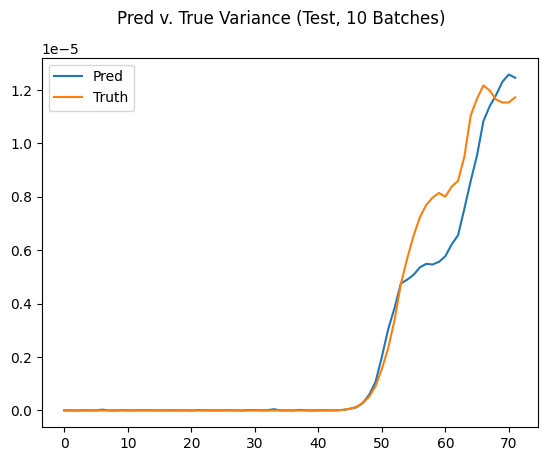

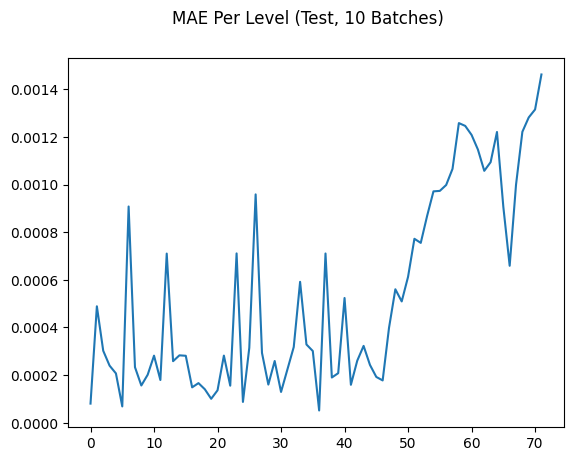

In [5]:
# Model Creation

hsel_train = train.features[instr]
spress_train = train.features[DKey.SURFACE_PRESSURE]

input_layers = train.get_input_layers()

hsel_input = input_layers[instr]
hsel_output = hsel_input

encoder = mlflow_logging.get_model("80ffa7825f2a47feab265a6729f6fa5b", "encoder.keras")
encoder.trainable = False
hsel_output = encoder(hsel_output)
hsel_output = LayerNormalization()(hsel_output)

spress_input = input_layers[DKey.SURFACE_PRESSURE]
spress_output = LayerNormalization())(spress_input)

activation = act.swish
size = 128
output = Concatenate()([hsel_output, spress_output])
output = Dense(size, activation)(output)
output = Dense(size, activation)(output)
output = Dense(size, activation)(output)
output = Dense(72)(output)
model = Model([hsel_input, spress_input], output)

model.compile(optimizer=opt.Adam(learning_rate=0.003), loss=losses.MAE, metrics=[metrics.MAE, metrics.MSE])

model.summary()

# Training

batch_size = 2000
# mlflow.log_param("memmap_batch_size", batch_size)

train_batches = train.create_batches(batch_size)
val_batches = validation.create_batches(batch_size)
test_batches = test.create_batches(batch_size)

early_stopping = callbacks.EarlyStopping(patience=5, verbose=1)
model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping],
)

# Evaluation
steps = 10
test_batches.shuffle = False
test_pred = model.predict(test_batches, steps=steps)
test_truth = test.target[0:steps*batch_size]

var = plots.plot_pred_truth_var(test_pred, test_truth, context="Test, 10 Batches", show=True)
mae = plots.plot_mae_per_level(test_pred, test_truth, context="Test, 10 Batches", show=True)
# log_eval_metrics(model, test_batches, "test")


1/1 [==============================] - 0s 103ms/step


(2000, 72)


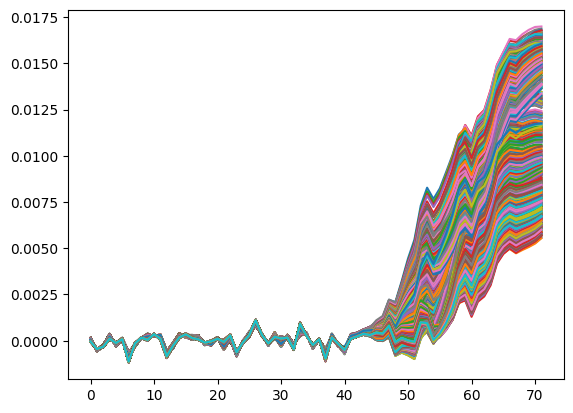

(2000, 72)


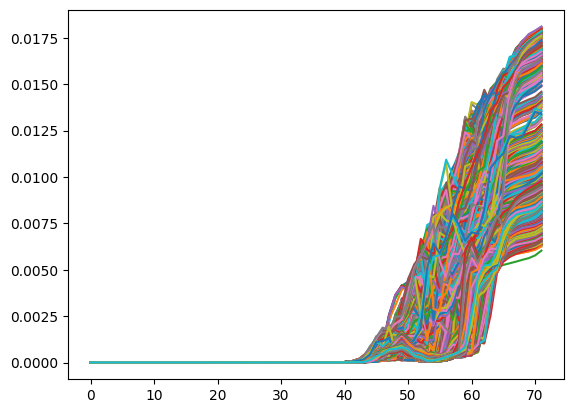

In [6]:
test_batches.shuffle = False

test_pred = model.predict(test_batches, steps=1)
print(test_pred.shape)
for pred in test_pred:
    plt.plot(pred)
plt.show()

test_pred = test.target[:batch_size]
print(test_pred.shape)
for pred in test_pred:
    plt.plot(pred)
plt.show()